In [1]:
import os
import shutil

# VISDRONE DATASET

In [2]:
root_path = '/Users/inaki-eab/Desktop/DETECTOR_DATASETS/'
#root_path = '/data-fast/127-data2/ierregue/datasets'

dataset_name = 'custom_visdrone'

new_dataset_root = os.path.join(root_path, dataset_name)

# Create folder structure
if not os.path.isdir(new_dataset_root):
    os.makedirs(new_dataset_root)
    os.makedirs(os.path.join(new_dataset_root, 'labels','train'))
    os.makedirs(os.path.join(new_dataset_root, 'labels','test'))
    os.makedirs(os.path.join(new_dataset_root, 'labels','val'))
    os.makedirs(os.path.join(new_dataset_root, 'images','train'))
    os.makedirs(os.path.join(new_dataset_root, 'images','test'))
    os.makedirs(os.path.join(new_dataset_root, 'images','val'))

## SELECTING DESIRED IMAGES AND MAPING

In [3]:
wanted_indices = [
    0, #airplane
    1, #boat
    2, #car
    3, #person
    4, #bus/truck
    5, #uav
]

In [4]:
def clean_map_file(file):
# Mapping should be performed only once
    
    class_index_map = {
        0:4, # airplane
        1:5, # boat
        2:1, # car
        3:0, # person
        4:2, # truck
        5:3, # uav
    }
    
    with open(file, 'r+') as fp:
        # read an store all lines into list
        lines = fp.readlines()
        # move file pointer to the beginning of a file
        fp.seek(0)
        # truncate the file
        fp.truncate()
    
        # start writing lines
        # iterate line and line number
        for number, line in enumerate(lines):
            # Only write rows of interested instances
            old_class_id = int(line.split()[0])
            if old_class_id in wanted_indices:
                # map old class indices to new ones
                new_class_id = class_index_map[old_class_id]
                new_line_splitted = line.split()
                new_line_splitted[0] = str(new_class_id)
                new_line = ' '.join(new_line_splitted)
                fp.write(new_line+'\n')

In [5]:
def move_desired_files(
    original_dataset_root, #../datasets/old_dataset
    target_dataset_root, # ../datasets/new_dataset
    original_dataset_slice, # liketrain,test,val
    target_dataset_slice, # train,test,val
    wanted_indices # list of desired indices
):
    # Empty list to store the selected files containing at list one of the desired objects
    selected_images = []
    
    
    original_labels_dir = os.path.join(original_dataset_root, 'labels', original_dataset_slice)
    original_images_dir = os.path.join(original_dataset_root, 'images', original_dataset_slice)

    # Iterate over all files in the original dataset labels folder
    for filename in os.listdir(original_labels_dir):
        if filename.endswith('.txt'):
            # Read file
            with open(os.path.join(original_labels_dir, filename), "r") as f:
                # Empty list to store objects/instances present in image
                indices_in_file = []
                # Iterate over instances in image and get present class ids
                for line in f:
                    indices_in_file.append(int(line.split()[0]))
                # If any present class ids is a class id of interest, get its filename
                if any((True for x in indices_in_file if x in wanted_indices)):
                    # Get only name, no '.txt' extension
                    selected_images.append(os.path.splitext(filename)[0])
                    # Copy *.txt folder
                    shutil.copy(os.path.join(original_labels_dir, filename), os.path.join(target_dataset_root, 'labels', target_dataset_slice))
                    # Copy *jpg image
                    img_path = os.path.join(original_images_dir, os.path.splitext(filename)[0]+'.jpg')
                    shutil.copy(img_path, os.path.join(target_dataset_root, 'images', target_dataset_slice))

                    # Map old index to new one and delete unwanted instances
                    clean_map_file(os.path.join(target_dataset_root, 'labels', target_dataset_slice, filename))
                    
    return selected_images

In [6]:
original_dataset_path = 'visdrone'
original_dataset_root = os.path.join(root_path, original_dataset_path)

In [7]:
val_indices = move_desired_files(original_dataset_root, 
                                   new_dataset_root, 
                                   'val', 
                                   'val', 
                                   wanted_indices)

In [8]:
train_indices = move_desired_files(original_dataset_root, 
                                   new_dataset_root, 
                                   'train', 
                                   'train', 
                                   wanted_indices)

In [9]:
old_len_img_train = len(os.listdir(os.path.join(new_dataset_root,'images','train')))
old_len_img_val = len(os.listdir(os.path.join(new_dataset_root,'images','val')))
old_len_txt_val = len(os.listdir(os.path.join(new_dataset_root,'labels','val')))
old_len_txt_train = len(os.listdir(os.path.join(new_dataset_root,'labels','train')))

In [10]:
import re

def rename_dir(dir, shift=1):
    files = [f for f in os.listdir(dir)]
    #files.sort(key=lambda x: int(re.match(r'\d+', x).group()))
    files.sort()
    
    for idx, old_filename in enumerate(files):
        extension = os.path.splitext(old_filename)[1]
        new_filename = f'{idx+shift}{extension}'
        old_path = os.path.join(dir, old_filename)
        new_path = os.path.join(dir, new_filename)
        os.rename(old_path, new_path)

In [11]:
rename_dir(os.path.join(new_dataset_root,'images','train'), shift=1+127544)
rename_dir(os.path.join(new_dataset_root,'images','val'), shift=1+13205)
rename_dir(os.path.join(new_dataset_root,'labels','train'), shift=1+127544)
rename_dir(os.path.join(new_dataset_root,'labels','val'), shift=1+13205)

In [12]:
# CHECK THAT WE HAVE THE SAME NUMBER OF FILES
assert old_len_img_train == len(os.listdir(os.path.join(new_dataset_root,'images','train')))
assert old_len_img_val == len(os.listdir(os.path.join(new_dataset_root,'images','val')))
assert old_len_txt_val == len(os.listdir(os.path.join(new_dataset_root,'labels','val')))
assert old_len_txt_train == len(os.listdir(os.path.join(new_dataset_root,'labels','train')))

In [13]:
import pandas as pd
import imagesize
import matplotlib.pyplot as plt

In [14]:
class_names = {
    0:'person',
    1:'car', 
    2:'truck', 
    3:'uav', 
    4:'airplane', 
    5:'ship'
}

In [15]:
def inspect_dataset(
    target_dataset_root, # ../datasets/new_dataset
    target_dataset_slice, # train,test,val
):
    info = [] #list of lists, each list corresponds to an instance [cls_id, x, y, w, h, img]
    
    
    target_labels_dir = os.path.join(target_dataset_root, 'labels', target_dataset_slice)

    # Iterate over all files in the original dataset labels folder
    for filename in os.listdir(target_labels_dir):
        if filename.endswith('.txt'):
            # Read file
            with open(os.path.join(target_labels_dir, filename), "r") as f:
                # Iterate over instances in image and get present class ids
                for line in f:
                    line_data = []
                    # label data
                    line_data = line.split()
                    # Image name
                    line_data.append(os.path.splitext(filename)[0])
                    # Image size: could be done at image level and not row level
                    img_path = os.path.join(target_dataset_root,'images',target_dataset_slice, os.path.splitext(filename)[0]+'.jpg')
                    img_w, img_h = imagesize.get(img_path)
                    line_data.extend([img_w, img_h])
                    # Append line data to info
                    info.append(line_data)

    df = pd.DataFrame(info, columns=['new_class_id', 'xcn', 'ycn', 'wn', 'hn', 'img', 'img_w', 'img_h'])
    df = df.astype('float32').astype({'new_class_id':'int32', 'img':'int64'})
    df['class_name'] = df['new_class_id'].map(class_names)
    return df

In [16]:
df = inspect_dataset(new_dataset_root, 'train')
df

,new_class_id,xcn,ycn,wn,hn,img,img_w,img_h,class_name
0,0,0.494286,0.295714,0.002857,0.008571,132592,1400.0,1050.0,person
1,0,0.503929,0.407143,0.003571,0.008571,132592,1400.0,1050.0,person
2,0,0.498214,0.421905,0.002143,0.013333,132592,1400.0,1050.0,person
3,0,0.426429,0.428095,0.004286,0.010476,132592,1400.0,1050.0,person
4,2,0.262143,0.932857,0.064286,0.134286,132592,1400.0,1050.0,truck
...,...,...,...,...,...,...,...,...,...
305565,1,0.369360,0.109340,0.009760,0.006533,133695,2000.0,1500.0,car
305566,1,0.365080,0.114047,0.015865,0.007293,133695,2000.0,1500.0,car
305567,1,0.347085,0.110073,0.008375,0.008753,133695,2000.0,1500.0,car
305568,0,0.500535,0.103547,0.002110,0.008873,133695,2000.0,1500.0,person


In [17]:
print(f"The number of objects is {len(df)}")
print(f"The number of images is {len(df['img'].unique())}")

The number of objects is 305570
The number of images is 6458


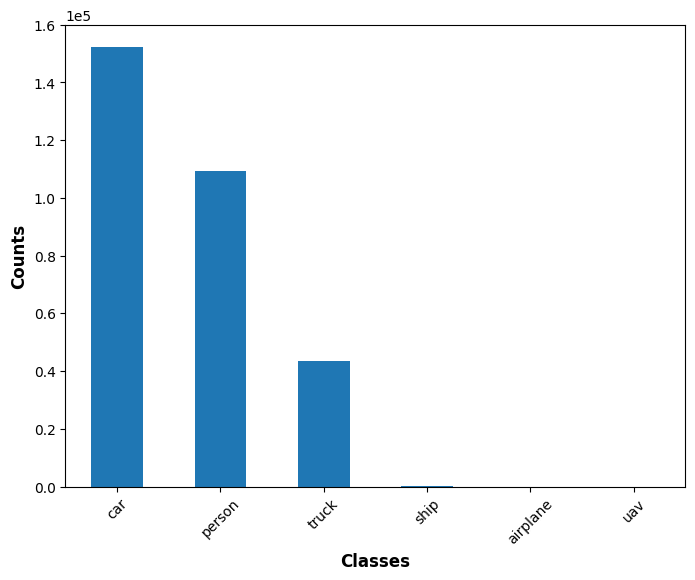

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = df['class_name'].value_counts().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Classes", weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
None

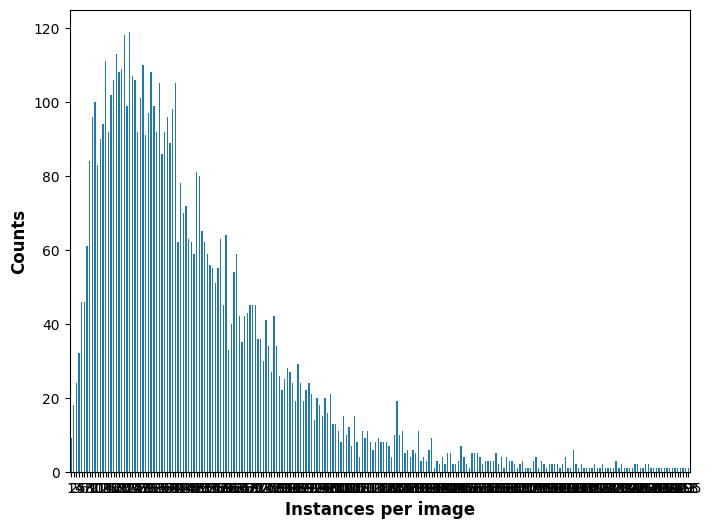

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = df.groupby(by=['img'])['img'].count().value_counts().sort_index().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Instances per image", weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
None

In [20]:
df['bbox_area'] = (df['wn']*df['img_w'])*(df['hn']*df['img_h'])
bin_edges = [0, 16**2, 32**2, 96**2, float('inf')]
bin_labels = ['tiny', 'small', 'medium', 'large']
df['bbox_size_category'] = pd.cut(df['bbox_area'], bins=bin_edges, labels=bin_labels, right=False)

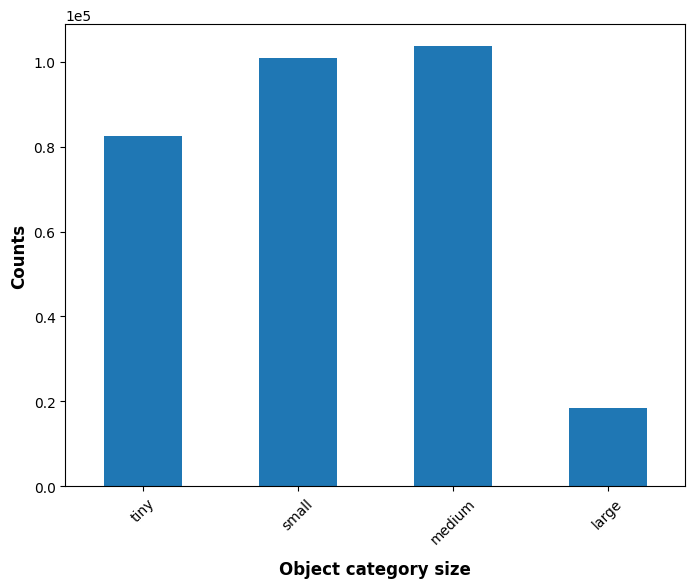

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = df['bbox_size_category'].value_counts().sort_index().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Object category size", weight='bold', size=12, labelpad=10)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
None